In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
base = '/Users/maxv/Dropbox (MIT)/inferring_expectations/'

In [2]:
gdb = gpd.read_file(base + 'data/ica_maps/p20/qa_vaq_elec_portal@viewer.gdb')
gdb = gdb.to_crs(epsg=2163)
gdb.head()

,CIRCUIT_NAME,SUBID,OHUG,LINE_SEGMENT_NUMBER,VOLTAGE,RES_PERC,AG_PERC,COM_PERC,IND_PERC,CON_GEN_CAP,QUE_GEN_CAP,TOTAL_GEN_CAP,LOAD_PROFILE,SHAPE_Length,geometry
0,163,CHOLLAS WEST,OH,38358,12,87,0,12,0,3.92,0.07,3.98,(576 Data Points),43.886541,"MULTILINESTRING ((-1590630.743 -1203448.118, -..."
1,163,CHOLLAS WEST,OH,52878,12,87,0,12,0,3.92,0.07,3.98,(576 Data Points),58.641850,"MULTILINESTRING ((-1591230.838 -1202778.356, -..."
2,163,CHOLLAS WEST,OH,47071,12,87,0,12,0,3.92,0.07,3.98,(576 Data Points),44.040562,"MULTILINESTRING ((-1589372.119 -1203637.404, -..."
3,163,CHOLLAS WEST,OH,51873,12,87,0,12,0,3.92,0.07,3.98,(576 Data Points),65.599363,"MULTILINESTRING ((-1589189.840 -1203550.161, -..."
4,163,CHOLLAS WEST,OH,49151,12,87,0,12,0,3.92,0.07,3.98,(576 Data Points),25.498384,"MULTILINESTRING ((-1589594.015 -1202317.280, -..."


In [3]:
circuit_frame = gdb[['CIRCUIT_NAME','SUBID','geometry']].dissolve(by='CIRCUIT_NAME')
circuit_frame.head()

,geometry,SUBID
CIRCUIT_NAME,,
100,"MULTILINESTRING ((-1604543.894 -1195329.265, -...",OLD TOWN
1001,"MULTILINESTRING ((-1597863.400 -1166472.787, -...",RANCHO SANTA FE
1006,"MULTILINESTRING ((-1581693.641 -1212157.584, -...",PROCTOR VALLEY
1007,"MULTILINESTRING ((-1585858.833 -1212381.413, -...",PROCTOR VALLEY
1022,"MULTILINESTRING ((-1581521.616 -1145307.657, -...",LILAC


<AxesSubplot:>

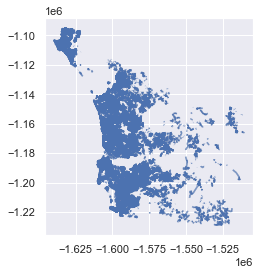

In [11]:
circuit_frame.plot()

In [4]:
import pandas as pd
psps = pd.read_csv(base + 'data/PSPS_event_data.csv',header=1)
psps.dropna(axis=1,how='all').head()

,Utility,Year,Outage Start,Full Restoration,Outage Duration,Outage Days,Outage Hours,Circuit Name,HFTD,TOTAL CUSTOMERS IMPACTED,RESIDENTIAL CUSTOMERS,COMMERCIAL/INDUSTRIAL CUSTOMERS,MEDICAL BASELINE CUSTOMERS,OTHER CUSTOMERS,Notes
0,SDG&E,2013,10/5/13 6:02,10/5/13 14:55,"0 days,8 hrs,53 min",0.37,8.88,79,NaN,85,NaN,NaN,NaN,NaN,NaN
1,SDG&E,2013,10/5/13 6:05,10/5/13 14:41,"0 days,8 hrs,36 min",0.358,8.6,TL 626 - CIRCUIT 238,NaN,2,NaN,NaN,NaN,NaN,NaN
2,SDG&E,2013,10/6/13 2:03,10/6/13 8:10,"0 days,6 hrs,7 min",0.255,6.12,79,NaN,83,NaN,NaN,NaN,NaN,NaN
3,SDG&E,2013,10/6/13 2:10,10/6/13 8:10,"0 days,6 hrs,0 min",0.25,6,79,NaN,11,NaN,NaN,NaN,NaN,NaN
4,SDG&E,2013,10/6/13 2:13,10/6/13 7:44,"0 days,5 hrs,31 min",0.23,5.52,TL 626 - CIRCUIT 238,NaN,2,NaN,NaN,NaN,NaN,NaN


In [8]:
sdge = psps[(psps.Utility.isin(['SDGE','SDG&E']))]
print(len(sdge))
with_hyphen = [x.year for x in sdge['Circuit Name'] if '-' in name]
np.unique(with_hyphen)

519


NameError: name 'year' is not defined

In [83]:
import numpy as np
import re
psps_names = pd.unique(psps[(psps.Utility.isin(['SDGE','SDG&E']))]['Circuit Name'])
def clean_name(name):
    if str(name)[-2:] == '*3': name = name.split('*3')[0]
    name = str(name).lower().strip()
    name = name.replace('-',' ')
    name = name.replace('–',' ')
    name = name.replace('*',' ')
    name = name.replace('  ',' ')
    name = name.replace('  ',' ')
    name = re.split(r'\[[0-9,.]\]',name)[0].strip()
    name = name.strip()
    return name
circuit_names = pd.unique([clean_name(name) for name in circuit_frame.reset_index()['CIRCUIT_NAME']])
new_names = []

def translate_name(name, circuit_names):
    """
    Looks for a match to a name from PSPS circuit names
    to the SDGE circuit map names
    Returns the match name, if found, or None if not 
    """
    name = clean_name(name)
#     name = name.replace('\xa0',' ')
    if name in circuit_names: return name
    if ' ' in name: 
        new_name = name.split(' ')[0]
        if new_name in circuit_names: 
            return new_name
    if 'cb' in name:
        new_name = clean_name(name.split('cb')[1])
        if new_name in circuit_names:
            return new_name
    if ', ' in name:
        new_name = name.split('gc sub')[1].strip() if 'gc sub' in name else name
        new_name = new_name.split(', ')
        if all([_name in circuit_names for _name in new_name]): return new_name
    return None
not_found = 0
for name in psps_names:
    new_name = translate_name(name, circuit_names)
    if new_name is None:
#         if translate_name(name.split('-')[0], circuit_names) is not None: continue
        print('-'*10 + 'not found: ' + name)
        not_found += 1
#     elif new_name != name.lower().strip():
#         print(name, '->', new_name)
print(not_found / len(psps_names))
# Note: 5 locations were not matched; these correspond to 5 total customers impacted

----------not found: TL 626 - CIRCUIT 238
----------not found: 238
----------not found: 1030
----------not found: TL 626
----------not found: TL 682
----------not found: 440
----------not found: 75
----------not found: 1250
----------not found: 283
----------not found: 212
----------not found: BC-TL626
----------not found: 1030-987
----------not found: 440-13R
----------not found: 440-8R
----------not found: F30159
----------not found: CTL1-3R*
----------not found: 1030-989R
----------not found: 75-1744R
----------not found: Generator
----------not found: 283-55R
----------not found: 283-71F
----------not found: 212-638R
----------not found: 212-632R
----------not found: 212-628R
----------not found: 212-630R
----------not found: 212-650R
----------not found: 212-652R
----------not found: 212-678R
----------not found: 212-680R
----------not found: CB 212
----------not found: CB 449 /449-6R
----------not found: F2280111
----------not found: 1243-45R
----------not found: DV1-3R
---------

In [82]:
gdb[(gdb.CIRCUIT_NAME == '444')]

,CIRCUIT_NAME,SUBID,OHUG,LINE_SEGMENT_NUMBER,VOLTAGE,RES_PERC,AG_PERC,COM_PERC,IND_PERC,CON_GEN_CAP,QUE_GEN_CAP,TOTAL_GEN_CAP,LOAD_PROFILE,SHAPE_Length,geometry


In [47]:
 pd.unique(gdb.CIRCUIT_NAME)

array(['163', '723', '155', '719', '733', '731', '972', '221', '161',
       '1081', '157', '591', '442', '222', '116', '203', '476', '859',
       '356', '51', '474', '350', '908', '67', '234', '387', '448', '79',
       '105', '230', '68', '357', '520', '66', '322', '532', '364', '237',
       '521', '1001', '599', '152', '330', '596', '168', '175', '176',
       '1435', '795', '411', '1073', '524', '296', '220', '1138', '415',
       '473', '242', '311', '80', '1215', '504', '377', '70', '835',
       '1235', '214', '759', '73', '42', '523', '396', '41', '321', '368',
       '907', '216', '1023', '450', '158', '215', '445', '172', '276',
       '166', '548', '1076', '151', '740', '471', '581', '480', '545',
       '240', '308', '492', '284', '326', '185', '279', '948', '286',
       '72', '199', '522', '206', '971', '363', '325', '704', '401',
       '353', '171', '789', '236', '39', '461', '305', '43', '1434',
       '376', '83', '288', '449', '351', '57', '191', '62', '1022', '55'